In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.7 MB/s eta 0:00:00a 0:00:01


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data, Dataset, DataLoader as PyGDataLoader
from torch_geometric.utils import to_networkx
from sklearn.neighbors import kneighbors_graph
import scipy.sparse

import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import time
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
SEED = 42
SUBSET_SIZE = 15000
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
RESIZE_DIM = 128

GAE_LATENT_DIM = 128
GAE_HIDDEN_DIM = 128
LEARNING_RATE_GAE = 1e-3
NUM_EPOCHS_GAE = 30
K_NEIGHBORS = 8

DATA_PATH = '/kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5'
VAE_WEIGHTS_PATH = '/kaggle/input/vae/pytorch/default/1/best_vae_model_weights-main.pth'
GAE_SAVE_PATH = './best_gae_model_weights.pth'

VAE_LATENT_DIM = 128
VAE_BASE_FILTERS = 32
VAE_INPUT_CHANNELS = 3

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Configuration:")
print(f"  SEED: {SEED}")
print(f"  SUBSET_SIZE: {SUBSET_SIZE}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  GAE_LATENT_DIM: {GAE_LATENT_DIM}")
print(f"  GAE_HIDDEN_DIM: {GAE_HIDDEN_DIM}")
print(f"  LEARNING_RATE_GAE: {LEARNING_RATE_GAE}")
print(f"  NUM_EPOCHS_GAE: {NUM_EPOCHS_GAE}")
print(f"  K_NEIGHBORS: {K_NEIGHBORS}")
print(f"  DATA_PATH: {DATA_PATH}")
print(f"  VAE_WEIGHTS_PATH: {VAE_WEIGHTS_PATH}")
print(f"  GAE_SAVE_PATH: {GAE_SAVE_PATH}")

Configuration:
  SEED: 42
  SUBSET_SIZE: 15000
  BATCH_SIZE: 64
  GAE_LATENT_DIM: 128
  GAE_HIDDEN_DIM: 128
  LEARNING_RATE_GAE: 0.001
  NUM_EPOCHS_GAE: 30
  K_NEIGHBORS: 8
  DATA_PATH: /kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5
  VAE_WEIGHTS_PATH: /kaggle/input/vae/pytorch/default/1/best_vae_model_weights-main.pth
  GAE_SAVE_PATH: ./best_gae_model_weights.pth


In [ ]:
def load_hdf5_data_raw(file_path, image_key='X_jets', label_key='y', subset_size=None):
    print(f"Loading raw data from: {file_path}")
    try:
        with h5py.File(file_path, 'r') as f:
            print("Keys in HDF5 file:", list(f.keys()))

            if image_key not in f:
                raise KeyError(f"Image key '{image_key}' not found in HDF5 file. Available keys: {list(f.keys())}")
            else:
                 labels_raw = f[label_key]

            images_raw = f[image_key]
            num_samples = images_raw.shape[0]
            print(f"Found {num_samples} total samples.")

            if subset_size is not None and subset_size > 0 and subset_size < num_samples:
                print(f"Selecting a random subset of {subset_size} samples.")
                np.random.seed(SEED)
                indices = np.random.choice(num_samples, subset_size, replace=False)
                indices = np.sort(indices)
                images_loaded = images_raw[indices]
                if labels_raw is not None:
                    labels_loaded = labels_raw[indices]
                else:
                    labels_loaded = np.zeros(subset_size)
            else:
                print(f"Using all {num_samples} available samples.")
                images_loaded = images_raw[:]
                if labels_raw is not None:
                     labels_loaded = labels_raw[:]
                else:
                     labels_loaded = np.zeros(num_samples)

            print(f"Loaded raw images shape: {images_loaded.shape}")
            print(f"Loaded labels shape: {labels_loaded.shape}")

            if images_loaded.ndim == 4 and images_loaded.shape[3] == VAE_INPUT_CHANNELS:
                images_tensor = torch.tensor(images_loaded, dtype=torch.float32).permute(0, 3, 1, 2)
                print(f"Converted to tensor shape: {images_tensor.shape}")
            else:
                 raise ValueError(f"Unexpected raw image dimensions: {images_loaded.shape}. Expected (N, H, W, C) with C={VAE_INPUT_CHANNELS}")

            labels_tensor = torch.tensor(labels_loaded, dtype=torch.long)

            del images_loaded

    except Exception as e:
        print(f"Error loading HDF5 data: {e}")
        raise

    return images_tensor, labels_tensor
raw_images_tensor, labels_tensor = load_hdf5_data_raw(DATA_PATH, image_key='X_jets', subset_size=SUBSET_SIZE)

print(f"\nRaw images tensor shape: {raw_images_tensor.shape}")
print(f"Labels tensor shape: {labels_tensor.shape}")

Loading raw data from: /kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5
Keys in HDF5 file: ['X_jets', 'm0', 'pt', 'y']
Found 139306 total samples.
Selecting a random subset of 15000 samples.
Loaded raw images shape: (15000, 125, 125, 3)
Loaded labels shape: (15000,)
Converted to tensor shape: torch.Size([15000, 3, 125, 125])

Raw images tensor shape: torch.Size([15000, 3, 125, 125])
Labels tensor shape: torch.Size([15000])


In [ ]:
if raw_images_tensor.shape[-2:] != (RESIZE_DIM, RESIZE_DIM):
    print(f"\nResizing images from {raw_images_tensor.shape[-2:]} to ({RESIZE_DIM}, {RESIZE_DIM})...")
    images_resized = F.interpolate(raw_images_tensor, size=(RESIZE_DIM, RESIZE_DIM), mode='bilinear', align_corners=False)
else:
    print("\nImages already at target size.")
    images_resized = raw_images_tensor
print(f"Resized images tensor shape: {images_resized.shape}")
del raw_images_tensor

n_total = len(images_resized)
n_val = int(VALIDATION_SPLIT * n_total)
n_train = n_total - n_val

indices = torch.randperm(n_total, generator=torch.Generator().manual_seed(SEED))
train_indices = indices[:n_train]
val_indices = indices[n_train:]

print(f"\nSplitting resized data into {n_train} training and {n_val} validation samples.")

print("Calculating normalization statistics on the training set split...")
train_data_for_norm = images_resized[train_indices]

channel_means = train_data_for_norm.mean(dim=[0, 2, 3], keepdim=True) # Shape: (1, C, 1, 1)
channel_stds = train_data_for_norm.std(dim=[0, 2, 3], keepdim=True)   # Shape: (1, C, 1, 1)


epsilon_norm = 1e-6 #to preven 0 division
channel_stds[channel_stds < epsilon_norm] = epsilon_norm

print(f"Channel Means: {channel_means.squeeze().tolist()}")
print(f"Channel Stds: {channel_stds.squeeze().tolist()}")

print("Applying normalization to the entire dataset...")
original_images_tensor = (images_resized - channel_means) / channel_stds
del images_resized

print(f"Standardized images tensor shape: {original_images_tensor.shape}")

sample_train_idx_in_original = train_indices[0]
print(f"Sample normalized train image (mean): {original_images_tensor[sample_train_idx_in_original].mean():.4f}, "
      f"(std): {original_images_tensor[sample_train_idx_in_original].std():.4f} (Note: std per image != 1)")
sample_val_idx_in_original = val_indices[0]
print(f"Sample normalized val image (mean): {original_images_tensor[sample_val_idx_in_original].mean():.4f}, "
      f"(std): {original_images_tensor[sample_val_idx_in_original].std():.4f}")
print(f"\nCreated train_indices (len {len(train_indices)}) and val_indices (len {len(val_indices)})")
normalization_means = channel_means
normalization_stds = channel_stds
print("Stored normalization_means and normalization_stds for later use.")


Resizing images from torch.Size([125, 125]) to (128, 128)...
Resized images tensor shape: torch.Size([15000, 3, 128, 128])

Splitting resized data into 12000 training and 3000 validation samples.
Calculating normalization statistics on the training set split...
Channel Means: [8.004522533155978e-05, 5.1089864427922294e-05, 3.035522240679711e-05]
Channel Stds: [0.005717707797884941, 0.001339102745987475, 0.00042471601045690477]
Applying normalization to the entire dataset...
Standardized images tensor shape: torch.Size([15000, 3, 128, 128])
Sample normalized train image (mean): -0.0059, (std): 0.4596 (Note: std per image != 1)
Sample normalized val image (mean): -0.0052, (std): 0.5615

Created train_indices (len 12000) and val_indices (len 3000)
Stored normalization_means and normalization_stds for later use.


This function is similar to the graph creation in the GNN notebook but adapted for the GAE task. No edge features are used in this GAE implementation. It stores the original pixel coordinates (graph_data.coords) and image dimensions (height, width) within the Data object, which will be needed later to map the reconstructed node features back onto an image grid.

In [ ]:
def create_graph_from_image(image_tensor, label, k_neighbors, include_coords=True):
    channels, height, width = image_tensor.shape

    image_tensor_cpu = image_tensor.cpu()

    energy_threshold = 1e-6
    mask = torch.sum(image_tensor_cpu, dim=0) > energy_threshold
    non_zero_coords = torch.nonzero(mask, as_tuple=False) # shape (num_points, 2) -> (row, col)

    num_points = non_zero_coords.shape[0]
    if num_points == 0:
        return None
    point_features = image_tensor[:, non_zero_coords[:, 0], non_zero_coords[:, 1]].T

    coords_norm = non_zero_coords.float() / torch.tensor([height - 1, width - 1], device=non_zero_coords.device)

    if include_coords:
        node_features = torch.cat([point_features, coords_norm], dim=1)
    else:
        node_features = point_features
    edge_index = None
    if num_points > 1:
        coords_np = coords_norm.cpu().numpy()
        actual_k = min(k_neighbors, num_points - 1)

        if actual_k > 0:
            A = kneighbors_graph(coords_np, n_neighbors=actual_k, mode='connectivity', include_self=False)
            coo = A.tocoo()
            row = torch.from_numpy(coo.row).to(torch.long)
            col = torch.from_numpy(coo.col).to(torch.long)
            edge_index = torch.stack([row, col], dim=0)
        else:
             edge_index = torch.empty((2, 0), dtype=torch.long)

    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
    graph_data = Data(x=node_features.to(image_tensor.device),
                      edge_index=edge_index.to(image_tensor.device),
                      y=label.to(image_tensor.device))
    graph_data.num_nodes = num_points
    graph_data.height = height
    graph_data.width = width
    graph_data.coords = non_zero_coords.to(image_tensor.device)

    return graph_data
graph_list = []
print(f"Converting {original_images_tensor.shape[0]} images to graphs (using sklearn KNN)...")
for i in tqdm(range(original_images_tensor.shape[0])):
    graph = create_graph_from_image(
        original_images_tensor[i],
        labels_tensor[i],
        k_neighbors=K_NEIGHBORS,
        include_coords=True
    )
    if graph is not None:
        graph_list.append(graph)

print(f"Successfully converted {len(graph_list)} images into graphs.")
if len(graph_list) < original_images_tensor.shape[0]:
    print(f"Skipped {original_images_tensor.shape[0] - len(graph_list)} images with no non-zero pixels above threshold.")

Converting 15000 images to graphs (using sklearn KNN)...


  0%|          | 0/15000 [00:00<?, ?it/s]

Successfully converted 15000 images into graphs.


In [ ]:
from torch.utils.data import random_split

class JetGraphDataset(Dataset):
    def __init__(self, data_list):
        super().__init__(None)
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

full_dataset = JetGraphDataset(graph_list)

num_graphs = len(full_dataset)
num_val = int(num_graphs * VALIDATION_SPLIT)
num_train = num_graphs - num_val

print(f"Total graphs: {num_graphs}")
print(f"Splitting into {num_train} training and {num_val} validation graphs.")

train_dataset, val_dataset = random_split(full_dataset, [num_train, num_val],
                                          generator=torch.Generator().manual_seed(SEED))

train_loader = PyGDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = PyGDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Created DataLoaders:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")

try:
    first_batch = next(iter(train_loader))
    print("\n--- Sample Batch Info ---")
    print(first_batch)
    print(f"Number of graphs in batch: {first_batch.num_graphs}")
    print(f"Node features shape: {first_batch.x.shape}")
    print(f"Edge index shape: {first_batch.edge_index.shape}")
    print(f"Batch vector shape: {first_batch.batch.shape}")
    print(f"Labels shape: {first_batch.y.shape}")
    node_feature_dim = first_batch.num_node_features
    print(f"Detected Node Feature Dimension: {node_feature_dim}")
except StopIteration:
    print("Could not retrieve a batch, check dataset/loader.")
    node_feature_dim = VAE_INPUT_CHANNELS + 2
    print(f"Manually setting Node Feature Dimension: {node_feature_dim}")

Total graphs: 15000
Splitting into 12000 training and 3000 validation graphs.
Created DataLoaders:
  Train batches: 188
  Validation batches: 47


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



--- Sample Batch Info ---
DataBatch(x=[62031, 5], edge_index=[2, 496248], y=[64], num_nodes=62031, height=[64], width=[64], coords=[62031, 2], batch=[62031], ptr=[65])
Number of graphs in batch: 64
Node features shape: torch.Size([62031, 5])
Edge index shape: torch.Size([2, 496248])
Batch vector shape: torch.Size([62031])
Labels shape: torch.Size([64])
Detected Node Feature Dimension: 5


GAE_Encoder: Takes node features (x) and graph structure (edge_index) and encodes each node into a latent representation (z) using two GCN layers with batch normalization.
FeatureDecoder: A simple MLP that takes the latent embedding (z) of a single node and decodes it back to the original node feature dimension (5D in this case: ECAL, HCAL, Tracks, coord_y, coord_x).
GraphAutoencoder: Combines the encoder and decoder. The goal is for recon_x (reconstructed node features) to be as close as possible to the original x (input node features).

In [ ]:

class GAE_Encoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels) 
        self.conv2 = pyg_nn.GCNConv(hidden_channels, out_channels) 

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        # x = F.dropout(x, p=0.5, training=self.training)
        z = self.conv2(x, edge_index) 
        return z

class FeatureDecoder(nn.Module):
    def __init__(self, latent_channels, hidden_channels, out_channels):
        super().__init__()

        self.fc1 = nn.Linear(latent_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)


    def forward(self, z):
        z = F.relu(self.fc1(z))
        recon_features = self.fc2(z)
        return recon_features

class GraphAutoencoder(nn.Module):
    def __init__(self, node_feature_dim, gae_hidden_dim, gae_latent_dim):
        super().__init__()
        self.encoder = GAE_Encoder(node_feature_dim, gae_hidden_dim, gae_latent_dim)
        self.decoder = FeatureDecoder(gae_latent_dim, gae_hidden_dim, node_feature_dim)
        self.node_feature_dim = node_feature_dim
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        z = self.encoder(x, edge_index)
        recon_x = self.decoder(z)
        return recon_x

    def encode(self, data):
        x, edge_index = data.x, data.edge_index
        return self.encoder(x, edge_index)

    def decode(self, z):
        return self.decoder(z)

gae_model = GraphAutoencoder(
    node_feature_dim=node_feature_dim,
    gae_hidden_dim=GAE_HIDDEN_DIM,
    gae_latent_dim=GAE_LATENT_DIM
).to(device)

print(gae_model)
num_params_gae = sum(p.numel() for p in gae_model.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters in GAE: {num_params_gae:,}")

GraphAutoencoder(
  (encoder): GAE_Encoder(
    (conv1): GCNConv(5, 128)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GCNConv(128, 128)
  )
  (decoder): FeatureDecoder(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=5, bias=True)
  )
)

Number of trainable parameters in GAE: 34,693


In [ ]:
reconstruction_criterion = nn.MSELoss()
optimizer = optim.Adam(gae_model.parameters(), lr=LEARNING_RATE_GAE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)
print("Setup complete: Loss function (MSE), Optimizer (Adam), LR Scheduler (ReduceLROnPlateau)")

Setup complete: Loss function (MSE), Optimizer (Adam), LR Scheduler (ReduceLROnPlateau)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting GAE training for 30 epochs...


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/30 | Duration: 10.00s | Train Loss: 4.448260 | Val Loss: 2.552393 | LR: 1.0e-03
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/30 | Duration: 9.03s | Train Loss: 3.368642 | Val Loss: 2.460250 | LR: 1.0e-03
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/30 | Duration: 9.16s | Train Loss: 3.183380 | Val Loss: 2.470559 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/30 | Duration: 9.11s | Train Loss: 3.133199 | Val Loss: 2.281798 | LR: 1.0e-03
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/30 | Duration: 9.11s | Train Loss: 3.034451 | Val Loss: 2.305137 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/30 | Duration: 9.27s | Train Loss: 2.925105 | Val Loss: 2.184428 | LR: 1.0e-03
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/30 | Duration: 9.36s | Train Loss: 2.890876 | Val Loss: 2.088793 | LR: 1.0e-03
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/30 | Duration: 9.40s | Train Loss: 3.069419 | Val Loss: 2.670711 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/30 | Duration: 9.47s | Train Loss: 3.447002 | Val Loss: 2.100807 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/30 | Duration: 9.75s | Train Loss: 2.828446 | Val Loss: 2.133715 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/30 | Duration: 9.71s | Train Loss: 2.892537 | Val Loss: 2.188827 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/30 | Duration: 9.91s | Train Loss: 2.744199 | Val Loss: 2.100046 | LR: 1.0e-03


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/30 | Duration: 10.19s | Train Loss: 3.002478 | Val Loss: 2.254872 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/30 | Duration: 10.51s | Train Loss: 3.407017 | Val Loss: 1.975073 | LR: 5.0e-04
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/30 | Duration: 10.29s | Train Loss: 2.828110 | Val Loss: 2.072748 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/30 | Duration: 9.98s | Train Loss: 2.709533 | Val Loss: 2.047180 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/30 | Duration: 9.93s | Train Loss: 2.633288 | Val Loss: 2.041359 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/30 | Duration: 9.86s | Train Loss: 2.567058 | Val Loss: 1.966380 | LR: 5.0e-04
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/30 | Duration: 9.82s | Train Loss: 2.593664 | Val Loss: 1.989683 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/30 | Duration: 9.95s | Train Loss: 2.595291 | Val Loss: 1.896369 | LR: 5.0e-04
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 21/30 | Duration: 10.04s | Train Loss: 2.565751 | Val Loss: 1.943587 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 22/30 | Duration: 10.04s | Train Loss: 2.569338 | Val Loss: 2.408308 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 23/30 | Duration: 10.08s | Train Loss: 2.579423 | Val Loss: 2.003237 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 24/30 | Duration: 9.98s | Train Loss: 2.603769 | Val Loss: 1.870689 | LR: 5.0e-04
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 25/30 | Duration: 9.97s | Train Loss: 2.454317 | Val Loss: 1.868670 | LR: 5.0e-04
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 26/30 | Duration: 9.97s | Train Loss: 2.449681 | Val Loss: 1.967380 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 27/30 | Duration: 9.89s | Train Loss: 2.374568 | Val Loss: 1.855656 | LR: 5.0e-04
  -> New best validation loss. Saved model to ./best_gae_model_weights.pth


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 28/30 | Duration: 9.92s | Train Loss: 2.440413 | Val Loss: 2.128210 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 29/30 | Duration: 10.17s | Train Loss: 2.386061 | Val Loss: 1.977127 | LR: 5.0e-04


Training:   0%|          | 0/188 [00:00<?, ?it/s]

Validation:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 30/30 | Duration: 9.97s | Train Loss: 2.472310 | Val Loss: 2.013710 | LR: 5.0e-04

Training finished. Total time: 293.85s
Best Validation Loss: 1.855656


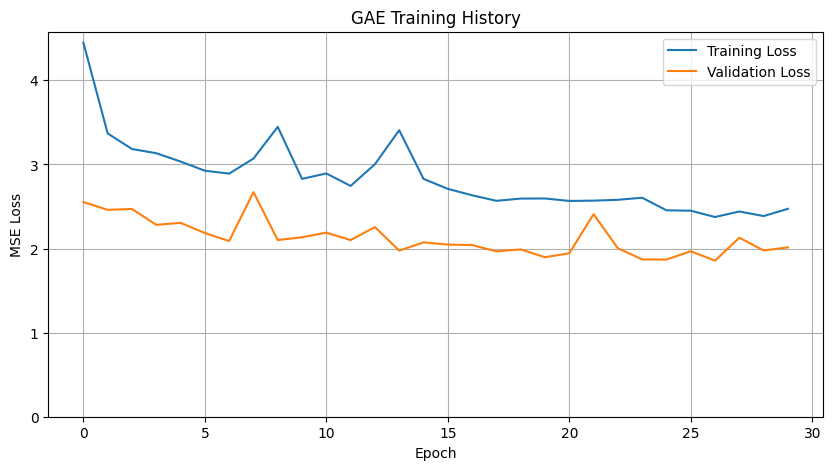

In [ ]:
def train_gae_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc="Training", leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()

        if not batch.x.dtype == torch.float32:
             batch.x = batch.x.float()

        recon_x = model(batch)

        target_x = batch.x
        if recon_x.shape != target_x.shape:
             raise ValueError(f"Shape mismatch: recon_x {recon_x.shape}, target_x {target_x.shape}")
        if recon_x.dtype != target_x.dtype:
             target_x = target_x.to(recon_x.dtype)
        loss = criterion(recon_x, target_x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

def evaluate_gae(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            batch = batch.to(device)

            if not batch.x.dtype == torch.float32:
                 batch.x = batch.x.float()

            recon_x = model(batch)
            target_x = batch.x

            if recon_x.shape != target_x.shape:
                 raise ValueError(f"Shape mismatch during eval: recon_x {recon_x.shape}, target_x {target_x.shape}")
            if recon_x.dtype != target_x.dtype:
                 target_x = target_x.to(recon_x.dtype)

            loss = criterion(recon_x, target_x)
            total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)

history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

print(f"Starting GAE training for {NUM_EPOCHS_GAE} epochs...")
start_time = time.time()

for epoch in range(NUM_EPOCHS_GAE):
    epoch_start_time = time.time()

    train_loss = train_gae_epoch(gae_model, train_loader, optimizer, reconstruction_criterion, device)
    val_loss = evaluate_gae(gae_model, val_loader, reconstruction_criterion, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Update LR scheduler
    scheduler.step(val_loss)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{NUM_EPOCHS_GAE} | Duration: {epoch_duration:.2f}s | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(gae_model.state_dict(), GAE_SAVE_PATH)
        print(f"  -> New best validation loss. Saved model to {GAE_SAVE_PATH}")

total_training_time = time.time() - start_time
print(f"\nTraining finished. Total time: {total_training_time:.2f}s")
print(f"Best Validation Loss: {best_val_loss:.6f}")

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('GAE Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

This is the same architecture used for VAE for the commin task. This is used for loading the VAE model and for comparisons

In [ ]:

RESIZE_DIM = RESIZE_DIM
LATENT_DIM = VAE_LATENT_DIM

class Encoder(nn.Module):
    def __init__(self, latent_dim, input_channels=3, base_filters=32):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, base_filters, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters*2, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters*2)
        self.conv3 = nn.Conv2d(base_filters*2, base_filters*4, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters*4)
        self.conv4 = nn.Conv2d(base_filters*4, base_filters*8, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters*8)

        self.flatten = nn.Flatten()
        flattened_size = base_filters*8 * (RESIZE_DIM // 16) * (RESIZE_DIM // 16)
        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels=3, base_filters=32):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.base_filters = base_filters
        self.unflatten_dim = base_filters*8
        self.unflatten_size = RESIZE_DIM // 16

        self.fc = nn.Linear(latent_dim, self.unflatten_dim * self.unflatten_size * self.unflatten_size)

        self.deconv1 = nn.ConvTranspose2d(self.unflatten_dim, base_filters*4, kernel_size=3, stride=2, padding=1, output_padding=1) # -> (base_filters*4, 16, 16)
        self.bn1 = nn.BatchNorm2d(base_filters*4)
        self.deconv2 = nn.ConvTranspose2d(base_filters*4, base_filters*2, kernel_size=3, stride=2, padding=1, output_padding=1) # -> (base_filters*2, 32, 32)
        self.bn2 = nn.BatchNorm2d(base_filters*2)
        self.deconv3 = nn.ConvTranspose2d(base_filters*2, base_filters, kernel_size=3, stride=2, padding=1, output_padding=1) # -> (base_filters, 64, 64)
        self.bn3 = nn.BatchNorm2d(base_filters)
        self.deconv4 = nn.ConvTranspose2d(base_filters, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1) # -> (output_channels, 128, 128)


    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, self.unflatten_dim, self.unflatten_size, self.unflatten_size)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = self.deconv4(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim, input_channels=3, base_filters=32):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, input_channels, base_filters)
        self.decoder = Decoder(latent_dim, input_channels, base_filters)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std # Sample z

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

    def reconstruct(self, x):
         mu, logvar = self.encoder(x)
         z = mu #  for deterministic reconstruction
         recon = self.decoder(z)
         return recon

def load_vae_model(weights_path, latent_dim, input_channels, base_filters, device):
    print(f"Loading VAE model structure...")
    model = VAE(latent_dim=latent_dim, input_channels=input_channels, base_filters=base_filters)
    print(f"Loading VAE weights from: {weights_path}")
    try:
        state_dict = torch.load(weights_path, map_location=device)

        if list(state_dict.keys())[0].startswith('module.'):
             state_dict = {k[len("module."):]: v for k, v in state_dict.items()}
             print("  Adjusted state_dict keys (removed 'module.' prefix).")

        model.load_state_dict(state_dict)
        print("  Successfully loaded VAE weights.")
    except FileNotFoundError:
        print(f"  Error: VAE weights file not found at {weights_path}")
        return None
    except Exception as e:
        print(f"  Error loading VAE weights: {e}")
        return None

    model.to(device)
    model.eval()
    return model
vae_model = load_vae_model(
    VAE_WEIGHTS_PATH,
    latent_dim=VAE_LATENT_DIM,
    input_channels=VAE_INPUT_CHANNELS,
    base_filters=VAE_BASE_FILTERS,
    device=device
)

if vae_model:
    print("Pre-trained VAE model loaded successfully.")
else:
    print("Could not load VAE model. Comparison plots will not include VAE.")

Loading VAE model structure...
Loading VAE weights from: /kaggle/input/vae/pytorch/default/1/best_vae_model_weights-main.pth


<ipython-input-11-6adc695100b7>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=device)


  Successfully loaded VAE weights.
Pre-trained VAE model loaded successfully.


This function takes the reconstructed node features (recon_x) from the GAE and maps them back onto a 2D image grid.
It retrieves the original pixel coordinates (coords) and image dimensions (height, width) that were saved in the graph_data object during graph creation. It extracts only the first 3 dimensions from the reconstructed node features (recon_x) This uses the original coords to place these reconstructed energy values onto the correct pixel locations in the recon_image.
The denormalize_image function (similar to VAE notebook) is used later to convert the normalized reconstructed image back to the original data scale for visualization.

In [ ]:

def graph_recon_to_image(recon_x, graph_data, include_coords=True):

    if recon_x is None or graph_data is None:
        return None

    coords = graph_data.coords.long()
    height = graph_data.height
    width = graph_data.width
    num_channels = VAE_INPUT_CHANNELS

    recon_image = torch.zeros((num_channels, height, width), device=recon_x.device)

    if include_coords:
         if recon_x.shape[1] < num_channels:
              print(f"Warning: recon_x has fewer features ({recon_x.shape[1]}) than expected channels ({num_channels}).")
              return None
         recon_energy = recon_x[:, :num_channels]
    else:
         recon_energy = recon_x
    valid_mask = (coords[:, 0] >= 0) & (coords[:, 0] < height) & \
                 (coords[:, 1] >= 0) & (coords[:, 1] < width)

    if not torch.all(valid_mask):
         print("Warning: Some coordinates out of bounds.")
         coords = coords[valid_mask]
         recon_energy = recon_energy[valid_mask]
    recon_image[:, coords[:, 0], coords[:, 1]] = recon_energy.T
    return recon_image

def denormalize_image(img_tensor, means, stds):

    if img_tensor is None:
        return None

    means = torch.as_tensor(means, dtype=img_tensor.dtype, device=img_tensor.device).squeeze()
    stds = torch.as_tensor(stds, dtype=img_tensor.dtype, device=img_tensor.device).squeeze()

    if means.ndim == 1:
        means = means[:, None, None]
    if stds.ndim == 1:
        stds = stds[:, None, None]


    # X_original = X_normalized * std + mean
    return img_tensor * stds + means


def visualize_reconstructions(original_img_norm, vae_recon_norm, gae_recon_norm, sample_idx, label, norm_means, norm_stds):
    original_img = denormalize_image(original_img_norm, norm_means, norm_stds)
    vae_recon = denormalize_image(vae_recon_norm, norm_means, norm_stds)
    gae_recon = denormalize_image(gae_recon_norm, norm_means, norm_stds)

    original_img_np = original_img.cpu().numpy().transpose(1, 2, 0) if original_img is not None else None# C, H, W -> H, W, C
    vae_recon_np = vae_recon.cpu().numpy().transpose(1, 2, 0) if vae_recon is not None else None
    gae_recon_np = gae_recon.cpu().numpy().transpose(1, 2, 0) if gae_recon is not None else None

    if original_img_np is None:
        print("Error: Original image is None, cannot visualize.")
        return

    positive_pixels = original_img_np[original_img_np > 0]
    if positive_pixels.size > 0:
         clim_max = np.percentile(positive_pixels, 99.9)
    else:
         clim_max = 1.0
    clim_min = 0
    clim_max = max(clim_max, 1e-3)

    num_plots = 1 + (1 if vae_recon_np is not None else 0) + (1 if gae_recon_np is not None else 0)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    if num_plots == 1: axes = [axes]
    fig.suptitle(f"Event {sample_idx} - Label: {'Quark' if label == 0 else 'Gluon'} (Label={label.item()}) [Denormalized]", fontsize=16)

    plot_idx = 0

    ax = axes[plot_idx]

    img_display_orig = np.sum(original_img_np, axis=2)
    im = ax.imshow(img_display_orig, cmap='magma', vmin=clim_min, vmax=clim_max)
    ax.set_title("Original (Denormalized)")
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plot_idx += 1


    if vae_recon_np is not None:
        ax = axes[plot_idx]
        img_display_vae = np.sum(vae_recon_np, axis=2)
        im = ax.imshow(img_display_vae, cmap='magma', vmin=clim_min, vmax=clim_max)
        ax.set_title("VAE Recon (Denormalized)")
        ax.set_xticks([])
        ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plot_idx += 1
    elif vae_model is not None:
         ax = axes[plot_idx]
         ax.set_title("VAE Recon (Failed/None)")
         ax.set_xticks([]); ax.set_yticks([])
         plot_idx += 1


    if gae_recon_np is not None:
        ax = axes[plot_idx]
        img_display_gae = np.sum(gae_recon_np, axis=2)
        im = ax.imshow(img_display_gae, cmap='magma', vmin=clim_min, vmax=clim_max)
        ax.set_title("GAE Recon (Denormalized)")
        ax.set_xticks([])
        ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plot_idx += 1
    elif gae_model_eval is not None:
         ax = axes[plot_idx]
         ax.set_title("GAE Recon (Failed/None)")
         ax.set_xticks([]); ax.set_yticks([])
         plot_idx += 1


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def calculate_mse(img1_norm, img2_norm):
    if img1_norm is None or img2_norm is None:
        return float('nan')
    if img1_norm.shape != img2_norm.shape:
        print(f"Warning: Image shape mismatch for MSE: {img1_norm.shape} vs {img2_norm.shape}")
        return float('nan')
#??
    img1_norm = img1_norm.to(device)
    img2_norm = img2_norm.to(device)
    return F.mse_loss(img1_norm, img2_norm).item()

Loading best trained GAE model...
Successfully loaded GAE model from ./best_gae_model_weights.pth

--- Generating Reconstructions for 5 Samples ---

Processing Sample 1 (Subset Idx: 1586, Original Idx: 11626)...
  VAE Reconstruction MSE (normalized): 0.209582
  GAE Reconstruction MSE (normalized): 0.048463


<ipython-input-19-e72a1e720cca>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gae_model_eval.load_state_dict(torch.load(GAE_SAVE_PATH, map_location=device))


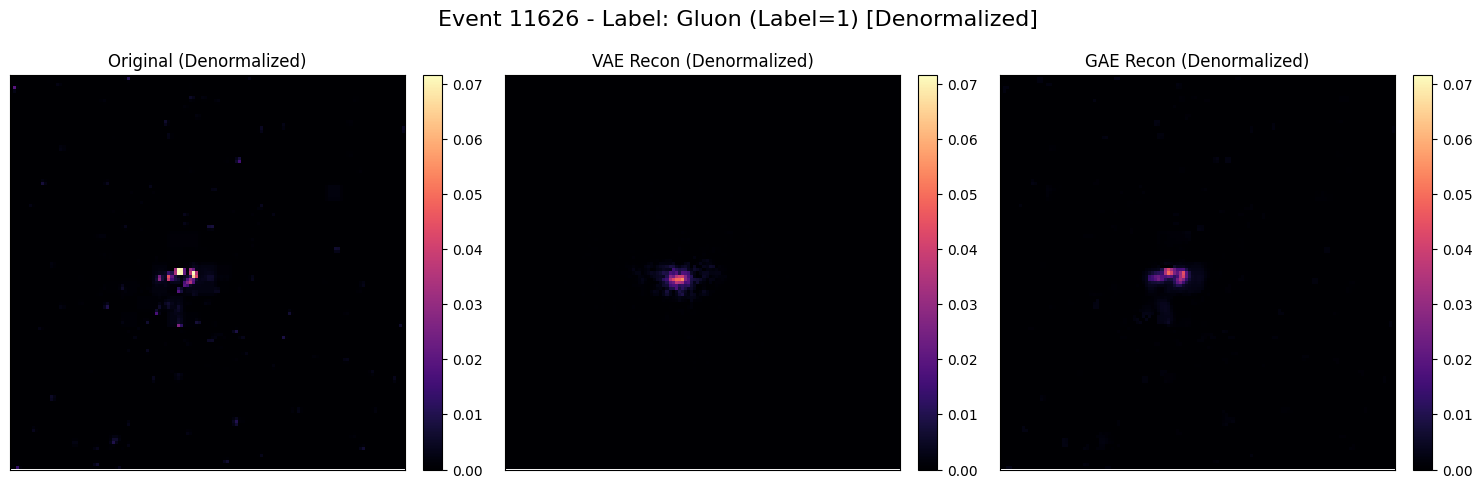


Processing Sample 2 (Subset Idx: 349, Original Idx: 4515)...
  VAE Reconstruction MSE (normalized): 0.177157
  GAE Reconstruction MSE (normalized): 0.071388


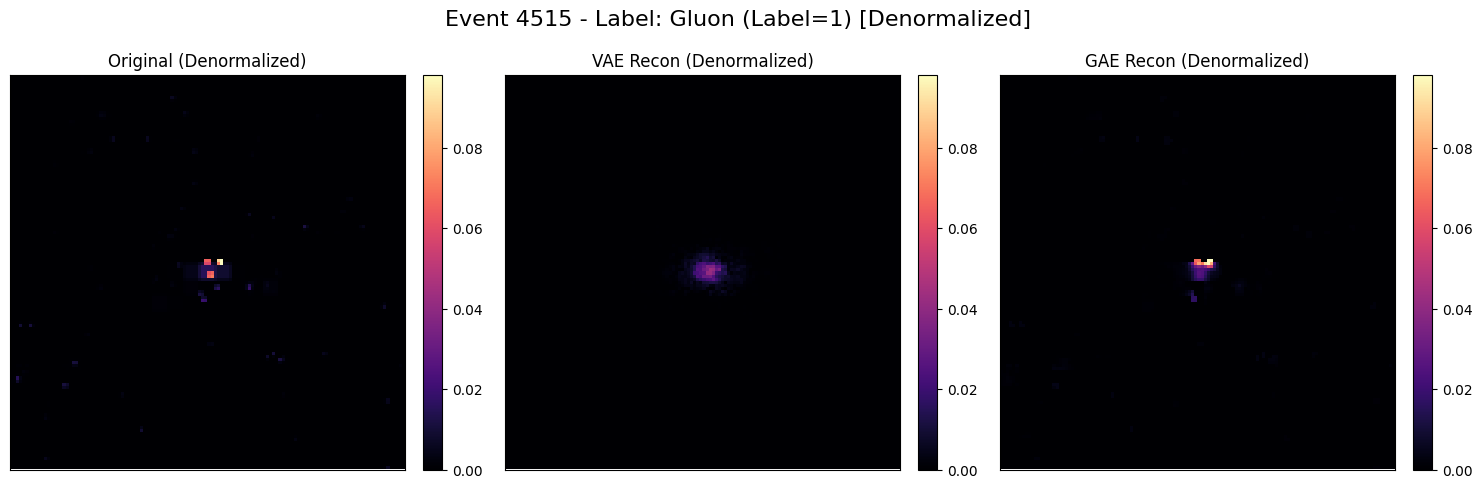


Processing Sample 3 (Subset Idx: 2567, Original Idx: 10712)...
  VAE Reconstruction MSE (normalized): 0.217396
  GAE Reconstruction MSE (normalized): 0.145806


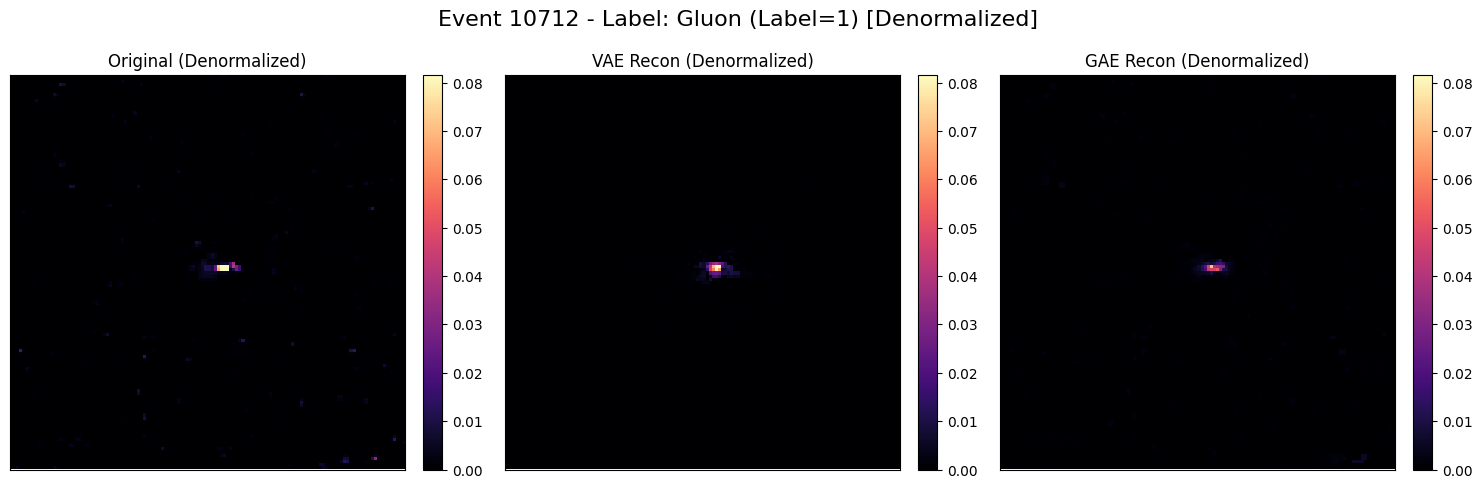


Processing Sample 4 (Subset Idx: 2469, Original Idx: 1217)...
  VAE Reconstruction MSE (normalized): 0.070197
  GAE Reconstruction MSE (normalized): 0.024947


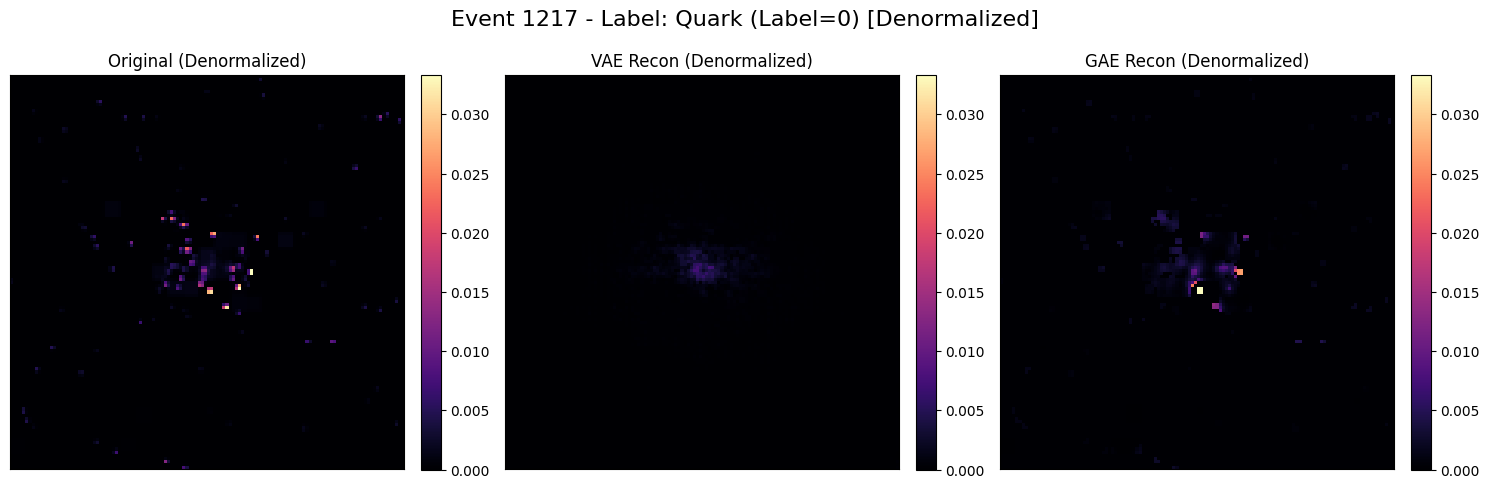


Processing Sample 5 (Subset Idx: 2816, Original Idx: 3647)...
  VAE Reconstruction MSE (normalized): 0.180200
  GAE Reconstruction MSE (normalized): 0.047784


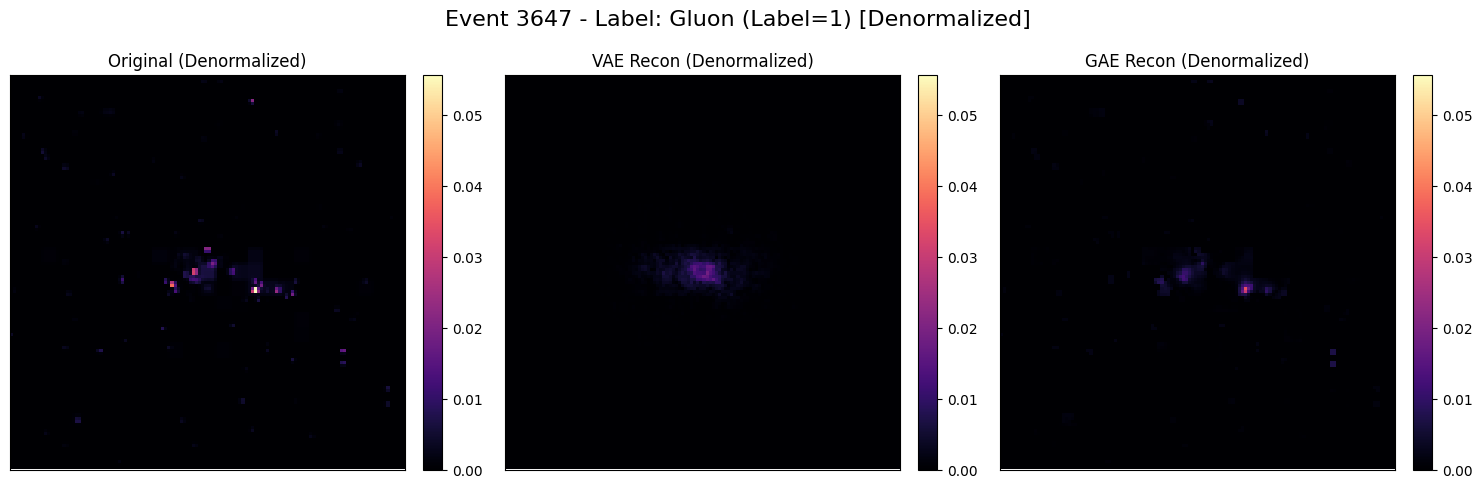


Average VAE Reconstruction MSE (normalized) over 5 samples: 0.170906
Average GAE Reconstruction MSE (normalized) over 5 samples: 0.067678

Evaluation Complete.


In [ ]:

print("Loading best trained GAE model...")

gae_model_eval = GraphAutoencoder(
    node_feature_dim=node_feature_dim,
    gae_hidden_dim=GAE_HIDDEN_DIM,
    gae_latent_dim=GAE_LATENT_DIM
)
try:
    gae_model_eval.load_state_dict(torch.load(GAE_SAVE_PATH, map_location=device))
    gae_model_eval.to(device)
    gae_model_eval.eval()
    print(f"Successfully loaded GAE model from {GAE_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Saved GAE model not found at {GAE_SAVE_PATH}. Cannot perform evaluation.")
    gae_model_eval = None
except Exception as e:
    print(f"Error loading saved GAE model: {e}")
    gae_model_eval = None

num_samples_to_show = 5
vis_indices = np.random.choice(len(val_dataset), num_samples_to_show, replace=False)


original_val_indices = val_dataset.indices

print(f"\n--- Generating Reconstructions for {num_samples_to_show} Samples ---")

vae_mses = []
gae_mses = []

val_graphs_subset = val_dataset

for i in range(num_samples_to_show):

    subset_idx = vis_indices[i]
    original_idx = val_indices[subset_idx]

    print(f"\nProcessing Sample {i+1} (Subset Idx: {subset_idx}, Original Idx: {original_idx})...")

    original_image_norm = original_images_tensor[original_idx].to(device) # Shape (C, H, W)
    label = labels_tensor[original_idx].to(device)

    graph_data_sample = val_graphs_subset[subset_idx]

    graph_data_sample = graph_data_sample.to(device)


    vae_recon_norm = None
    vae_mse = float('nan')
    if vae_model:
        vae_model.eval()
        with torch.no_grad():

            vae_input = original_image_norm.unsqueeze(0).to(device)
            vae_recon_norm = vae_model.reconstruct(vae_input).squeeze(0)

            vae_mse = calculate_mse(original_image_norm, vae_recon_norm)
            vae_mses.append(vae_mse)
            print(f"  VAE Reconstruction MSE (normalized): {vae_mse:.6f}")
    else:
        print("  VAE model not loaded, skipping VAE reconstruction.")

    gae_recon_image_norm = None
    gae_mse = float('nan')
    if gae_model_eval:
        gae_model_eval.eval()
        with torch.no_grad():
            if not graph_data_sample.x.dtype == torch.float32:
                graph_data_sample.x = graph_data_sample.x.float()

            recon_x_gae = gae_model_eval(graph_data_sample)

            gae_recon_image_norm = graph_recon_to_image(recon_x_gae, graph_data_sample, include_coords=True)

            if gae_recon_image_norm is not None:

                 gae_mse = calculate_mse(original_image_norm, gae_recon_image_norm)
                 gae_mses.append(gae_mse)
                 print(f"  GAE Reconstruction MSE (normalized): {gae_mse:.6f}")
            else:
                 print("  GAE reconstruction failed (likely no nodes or feature mismatch).")
    else:
        print("  GAE model not loaded, skipping GAE reconstruction.")



    visualize_reconstructions(
        original_image_norm,
        vae_recon_norm,
        gae_recon_image_norm,
        original_idx,
        label,
        normalization_means,
        normalization_stds
    )


if vae_mses:
    avg_vae_mse = np.nanmean(vae_mses)
    print(f"\nAverage VAE Reconstruction MSE (normalized) over {len(vae_mses)} samples: {avg_vae_mse:.6f}")
if gae_mses:
    avg_gae_mse = np.nanmean(gae_mses)
    print(f"Average GAE Reconstruction MSE (normalized) over {len(gae_mses)} samples: {avg_gae_mse:.6f}")

print("\nEvaluation Complete.")

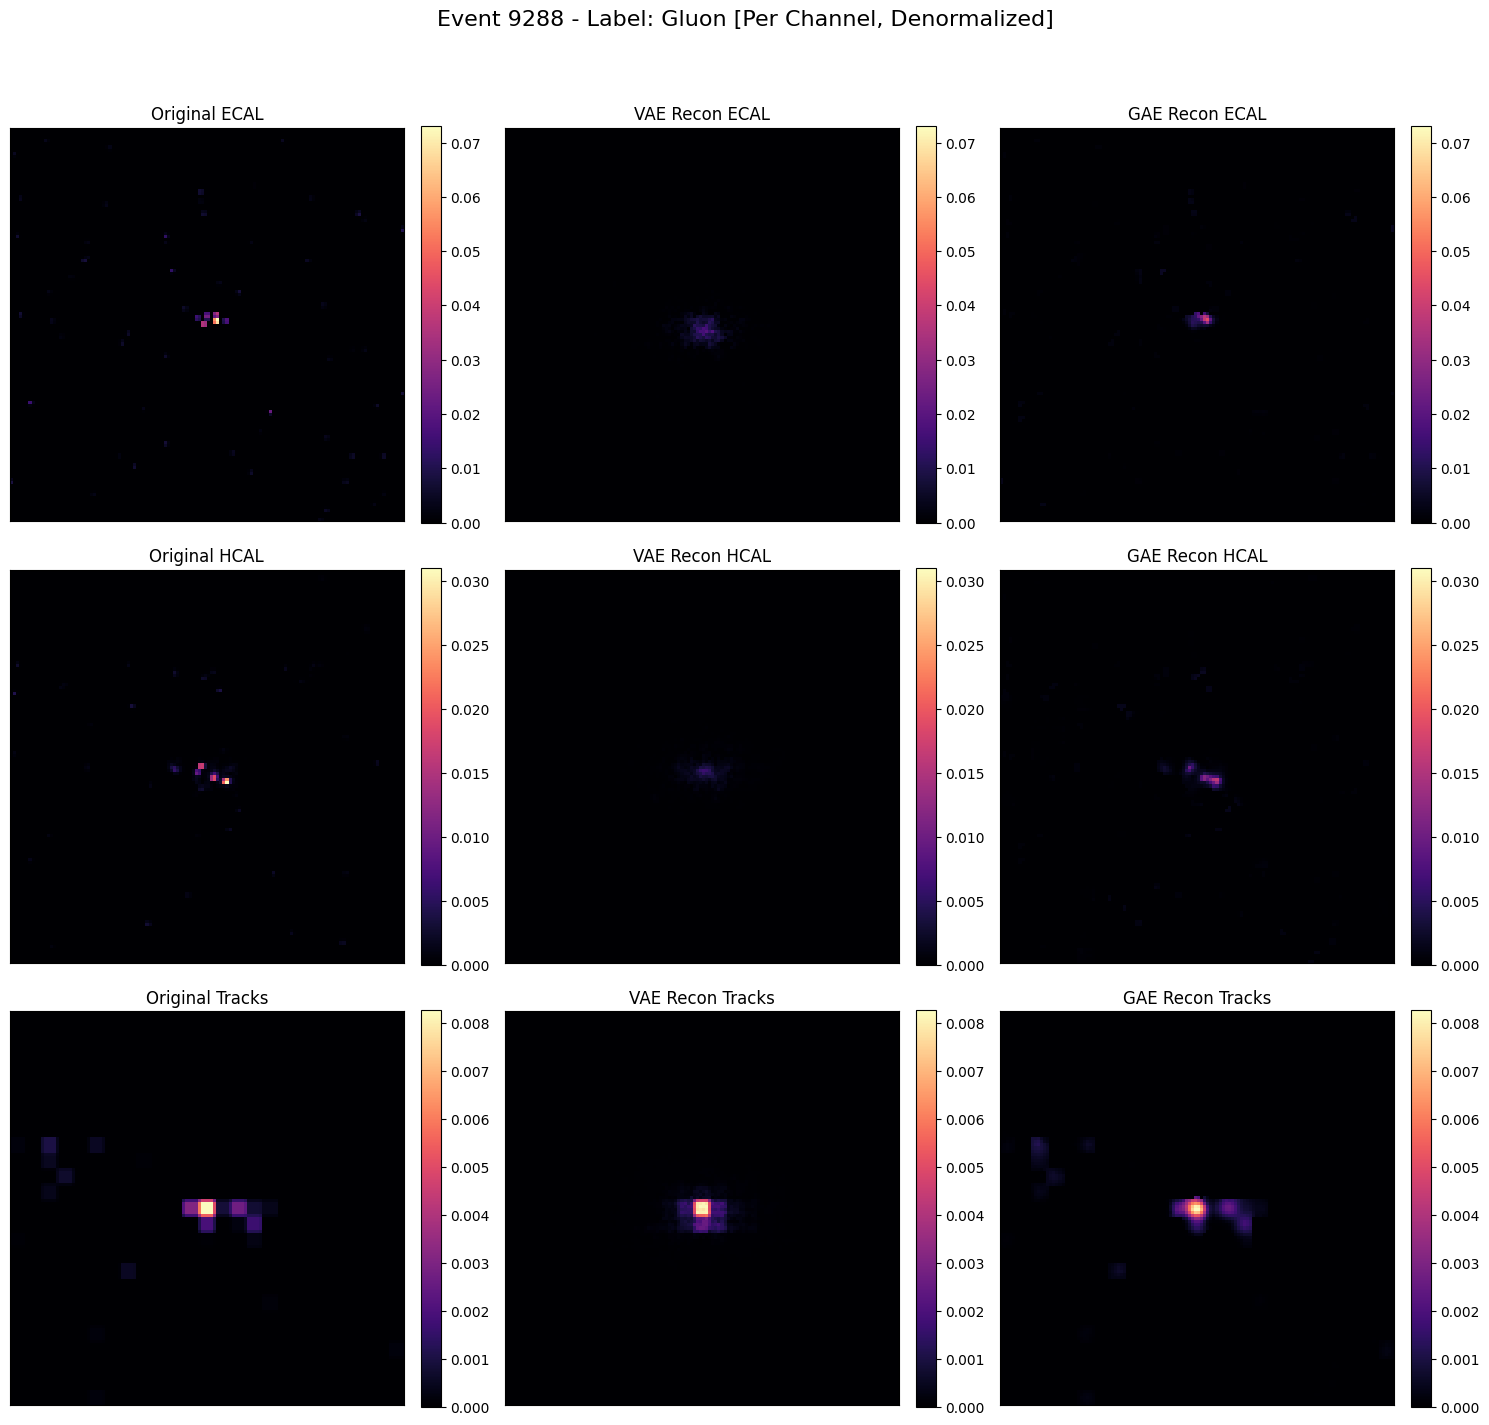

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def visualize_reconstructions_per_channel(original_img_norm, vae_recon_norm, gae_recon_norm, sample_idx, label, norm_means, norm_stds):


    channels = ['ECAL', 'HCAL', 'Tracks']
    num_channels = len(channels)
    original_img = denormalize_image(original_img_norm, norm_means, norm_stds)
    vae_recon = denormalize_image(vae_recon_norm, norm_means, norm_stds)
    gae_recon = denormalize_image(gae_recon_norm, norm_means, norm_stds)

    if original_img is None:
        print(f"Error: Cannot plot Event {sample_idx}, original image is None.")
        return

    fig, axes = plt.subplots(num_channels, 3, figsize=(15, 5 * num_channels)) # Rows=Channels, Cols=Orig/VAE/GAE
    fig.suptitle(f"Event {sample_idx} - Label: {'Quark' if label == 0 else 'Gluon'} [Per Channel, Denormalized]", fontsize=16)


    original_np = original_img.cpu().numpy()
    vae_np = vae_recon.cpu().numpy() if vae_recon is not None else None
    gae_np = gae_recon.cpu().numpy() if gae_recon is not None else None

    for i, channel_name in enumerate(channels):

        orig_channel_data = original_np[i, :, :]
        positive_pixels = orig_channel_data[orig_channel_data > 1e-6]
        if positive_pixels.size > 0:

             clim_max = np.percentile(positive_pixels, 99.9)
        else:
             clim_max = 1e-3
        clim_min = 0
        clim_max = max(clim_max, 1e-3)

        ax = axes[i, 0]
        im = ax.imshow(orig_channel_data, cmap='magma', vmin=clim_min, vmax=clim_max)
        ax.set_title(f"Original {channel_name}")
        ax.set_xticks([])
        ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        ax = axes[i, 1]
        if vae_np is not None:
            im = ax.imshow(vae_np[i, :, :], cmap='magma', vmin=clim_min, vmax=clim_max)
            ax.set_title(f"VAE Recon {channel_name}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.set_title(f"VAE Recon {channel_name} (N/A)")
        ax.set_xticks([])
        ax.set_yticks([])


        ax = axes[i, 2]
        if gae_np is not None:
            im = ax.imshow(gae_np[i, :, :], cmap='magma', vmin=clim_min, vmax=clim_max)
            ax.set_title(f"GAE Recon {channel_name}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.set_title(f"GAE Recon {channel_name} (N/A)")
        ax.set_xticks([])
        ax.set_yticks([])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_reconstructions_per_channel(
     original_image_norm,
     vae_recon_norm,
     gae_recon_image_norm,
     original_idx,
     label,
     normalization_means,
     normalization_stds
 )


In [ ]:

def calculate_all_mses(vae_model, gae_model, pyg_loader, full_image_tensor, subset_indices, device):
    vae_model.eval() if vae_model else None
    gae_model.eval() if gae_model else None

    all_vae_mses = []
    all_gae_mses = []
    processed_indices = []


    print(f"Calculating MSEs for {len(pyg_loader.dataset)} validation samples...")

    if len(subset_indices) != len(pyg_loader.dataset):
         if len(pyg_loader.dataset) < len(subset_indices):
              print("Assuming loader uses indices 0..N-1 relative to subset. Mapping via subset_indices.")
         else:
              print("Cannot reliably map loader index to original index. Aborting MSE calculation.")
              return [], [], []


    with torch.no_grad():
        batch_num = 0
        for i, graph_data_sample in enumerate(tqdm(pyg_loader.dataset, desc="Calculating MSEs")):

            original_idx = subset_indices[i]
            processed_indices.append(original_idx)

            original_image_norm = full_image_tensor[original_idx].to(device)

            vae_mse = float('nan')
            if vae_model:
                vae_input = original_image_norm.unsqueeze(0).to(device)
                vae_recon_norm = vae_model.reconstruct(vae_input).squeeze(0)
                vae_mse = calculate_mse(original_image_norm, vae_recon_norm)
            all_vae_mses.append(vae_mse)

            gae_mse = float('nan')
            if gae_model:
                graph_data_sample = graph_data_sample.to(device)
                if not graph_data_sample.x.dtype == torch.float32:
                    graph_data_sample.x = graph_data_sample.x.float()
                recon_x_gae = gae_model(graph_data_sample)
                gae_recon_image_norm = graph_recon_to_image(recon_x_gae, graph_data_sample, include_coords=True)
                if gae_recon_image_norm is not None:
                    gae_mse = calculate_mse(original_image_norm, gae_recon_image_norm)
            all_gae_mses.append(gae_mse)


    valid_indices = [idx for idx, gae_mse in enumerate(all_gae_mses) if not np.isnan(gae_mse)]
    filtered_vae_mses = [all_vae_mses[i] for i in valid_indices if not np.isnan(all_vae_mses[i])]
    filtered_gae_mses = [all_gae_mses[i] for i in valid_indices]
    filtered_processed_indices = [processed_indices[i] for i in valid_indices]


    print(f"Calculated {len(filtered_gae_mses)} valid MSE pairs.")
    if vae_model:
         print(f"  Avg VAE MSE (Eval Set): {np.mean(filtered_vae_mses):.6f}")
    if gae_model:
         print(f"  Avg GAE MSE (Eval Set): {np.mean(filtered_gae_mses):.6f}")

    return filtered_vae_mses, filtered_gae_mses, filtered_processed_indices


all_vae_mses, all_gae_mses, val_original_indices_used = calculate_all_mses(
    vae_model,
    gae_model_eval,
    val_loader,
    original_images_tensor,
    val_indices,
    device
)

Calculating MSEs for 3000 validation samples...


Calculating MSEs:   0%|          | 0/3000 [00:00<?, ?it/s]

Calculated 3000 valid MSE pairs.
  Avg VAE MSE (Eval Set): 0.516744
  Avg GAE MSE (Eval Set): 0.184959
